Historical Data Saved in an excel file with a dropbox link have been uploaded with Python Libraries.

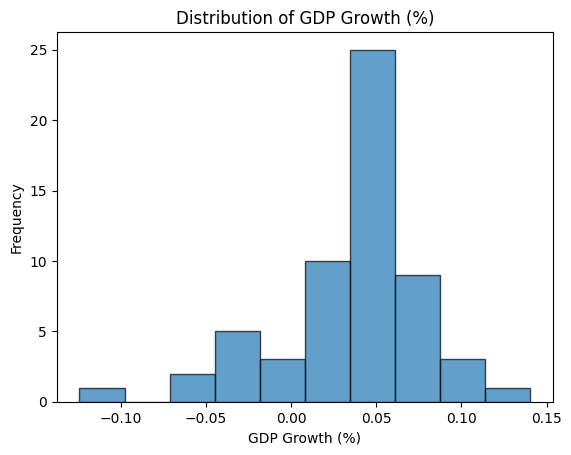

Summary statistics for GDP Growth (%):
count    59.000000
mean      0.036839
std       0.043620
min      -0.124300
25%       0.028700
50%       0.045000
75%       0.057650
max       0.140500
Name: GDP Growth (%), dtype: float64



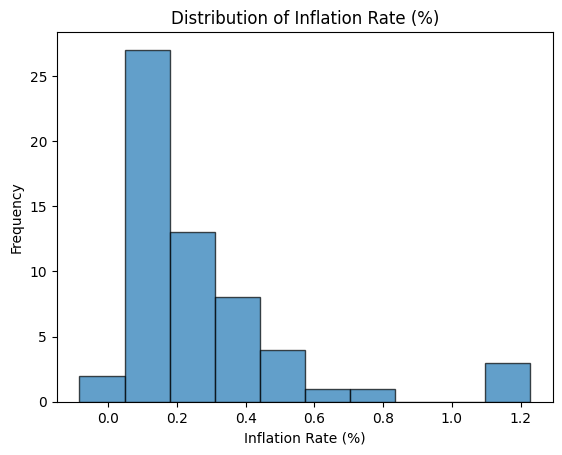

Summary statistics for Inflation Rate (%):
count    59.000000
mean      0.272468
std       0.265546
min      -0.084200
25%       0.105200
50%       0.180300
75%       0.343100
max       1.228700
Name: Inflation Rate (%), dtype: float64



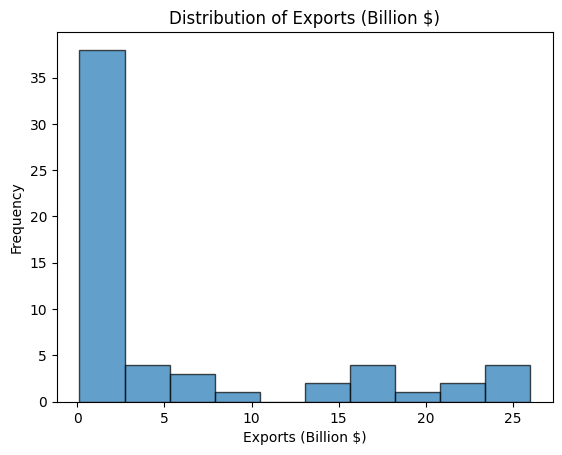

Summary statistics for Exports (Billion $):
count    59.000000
mean      5.852203
std       8.182955
min       0.130000
25%       0.445000
50%       1.380000
75%       7.405000
max      25.990000
Name: Exports (Billion $), dtype: float64



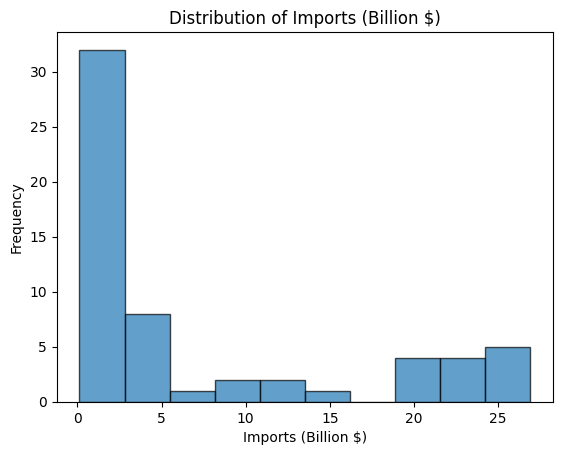

Summary statistics for Imports (Billion $):
count    59.000000
mean      7.166441
std       9.176490
min       0.120000
25%       0.490000
50%       2.130000
75%      11.890000
max      26.910000
Name: Imports (Billion $), dtype: float64



In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import requests

file_path = 'https://www.dropbox.com/scl/fi/iqqaq4fh46dmhc5ikh00e/Historical-Data-Ghana-2.xlsx?rlkey=1isps3yhxthlxi0nmz7h0yb99&dl=1'  # Changed dl=0 to dl=1

response = requests.get(file_path, stream=True)
response.raise_for_status()
content = response.content
data = pd.read_excel(io.BytesIO(content), sheet_name='Historical Data', engine='openpyxl')

# Clean the dataset and extract necessary columns
data_cleaned = data.copy()
data_cleaned['GDP Growth (%)'] = pd.to_numeric(data_cleaned['GDP Growth (%)'], errors='coerce')
data_cleaned['Inflation Rate (%)'] = pd.to_numeric(data_cleaned['Inflation Rate (%)'], errors='coerce')

# Assuming 'Billions of US $' represents exports and 'Billions of US $.1' represents imports
data_cleaned['Exports (Billion $)'] = data_cleaned['Billions of US $'].replace(
    '[\$,B]', '', regex=True).astype(float)
data_cleaned['Imports (Billion $)'] = data_cleaned['Billions of US $.1'].replace(
    '[\$,B]', '', regex=True).astype(float)

# Remove rows with missing or invalid data
data_cleaned = data_cleaned.dropna(subset=['GDP Growth (%)', 'Inflation Rate (%)', 'Exports (Billion $)', 'Imports (Billion $)'])

# Create summary statistics
summary_stats = data_cleaned[['GDP Growth (%)', 'Inflation Rate (%)', 'Exports (Billion $)', 'Imports (Billion $)']].describe()

# Visualize histograms for each variable
variables = ['GDP Growth (%)', 'Inflation Rate (%)', 'Exports (Billion $)', 'Imports (Billion $)']
for var in variables:
    plt.figure()
    plt.hist(data_cleaned[var], bins=10, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()
    print(f"Summary statistics for {var}:\n{data_cleaned[var].describe()}\n")

In [ ]:
import statsmodels.api as sm

# Define dependent and independent variables
X = data_cleaned[['Inflation Rate (%)', 'Exports (Billion $)', 'Imports (Billion $)']]
y = data_cleaned['GDP Growth (%)']

# Add a constant for the intercept term
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Display the summary of the regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         GDP Growth (%)   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     5.731
Date:                Sat, 23 Nov 2024   Prob (F-statistic):            0.00174
Time:                        17:32:48   Log-Likelihood:                 109.61
No. Observations:                  59   AIC:                            -211.2
Df Residuals:                      55   BIC:                            -202.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0349    

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns
print(vif)


   VIF Factor              Feature
0    3.789592                const
1    1.142194   Inflation Rate (%)
2   40.701357  Exports (Billion $)
3   41.531815  Imports (Billion $)


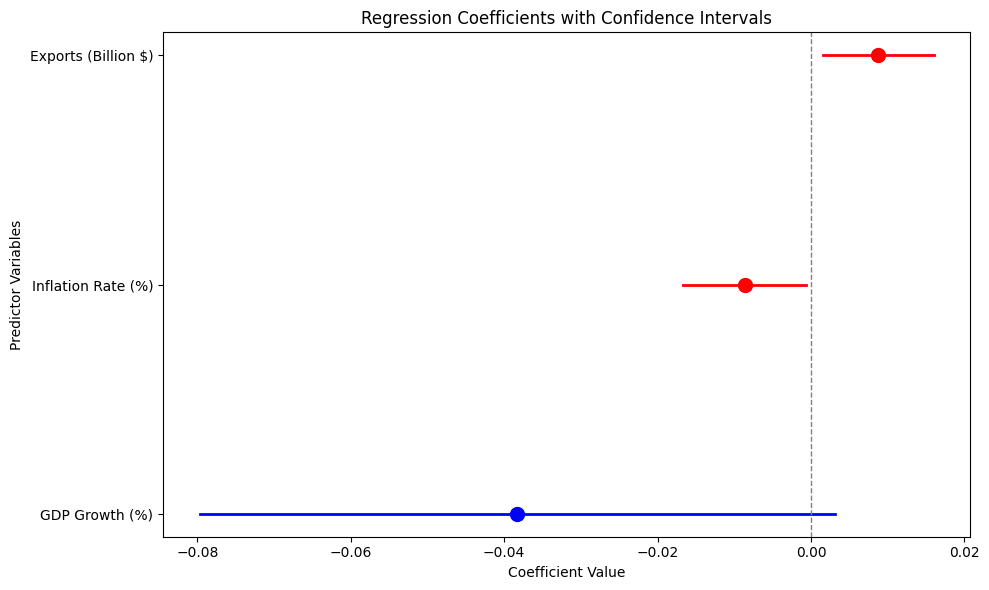

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ... (Your previous code to load and clean data, fit the regression model)

# Get coefficients, confidence intervals, and p-values from the model
coef_values = model.params[1:]  # Excluding the intercept
conf_int = model.conf_int(alpha=0.05)  # 95% confidence interval
lower_bounds = conf_int[0][1:]
upper_bounds = conf_int[1][1:]
p_values = model.pvalues[1:]  # Excluding the intercept

# Define significance based on p-values (e.g., p < 0.05)
significance = [p < 0.05 for p in p_values]

# Correcting the visualization of regression coefficients
plt.figure(figsize=(10, 6))

# Assigning colors based on significance
colors = ['red' if sig else 'blue' for sig in significance]

# Plotting coefficients with error bars
for i, (coef, lower, upper, color) in enumerate(zip(coef_values, lower_bounds, upper_bounds, colors)):
    plt.plot([lower, upper], [variables[i], variables[i]], color=color, linestyle='-', linewidth=2)
    plt.scatter(coef, variables[i], color=color, s=100)

# Adding a reference line for zero
plt.axvline(0, color='gray', linestyle='--', linewidth=1)

# Formatting the plot
plt.title("Regression Coefficients with Confidence Intervals")
plt.xlabel("Coefficient Value")
plt.ylabel("Predictor Variables")
plt.tight_layout()
plt.show()


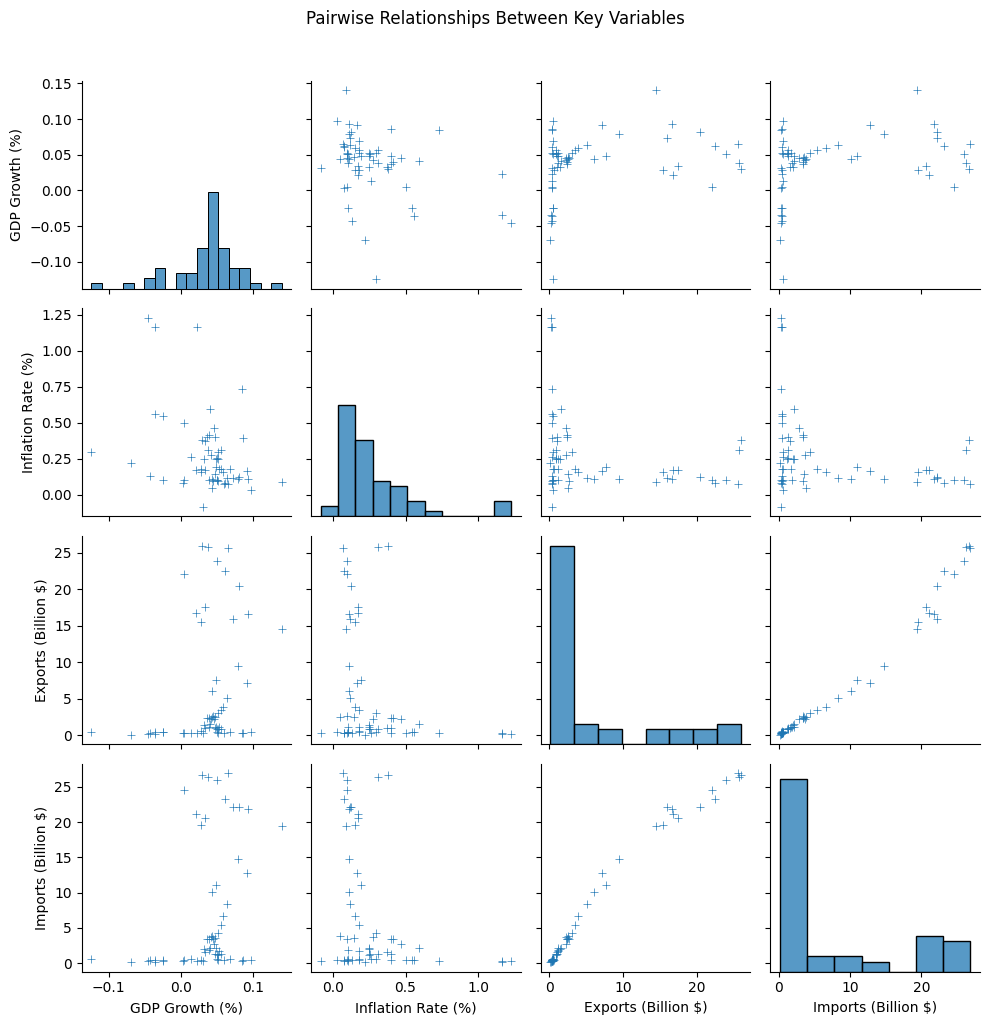

Correlation Matrix of Key Variables:
                     GDP Growth (%)  Inflation Rate (%)  Exports (Billion $)  \
GDP Growth (%)             1.000000           -0.353858             0.266433   
Inflation Rate (%)        -0.353858            1.000000            -0.274557   
Exports (Billion $)        0.266433           -0.274557             1.000000   
Imports (Billion $)        0.318170           -0.306382             0.987204   

                     Imports (Billion $)  
GDP Growth (%)                  0.318170  
Inflation Rate (%)             -0.306382  
Exports (Billion $)             0.987204  
Imports (Billion $)             1.000000  


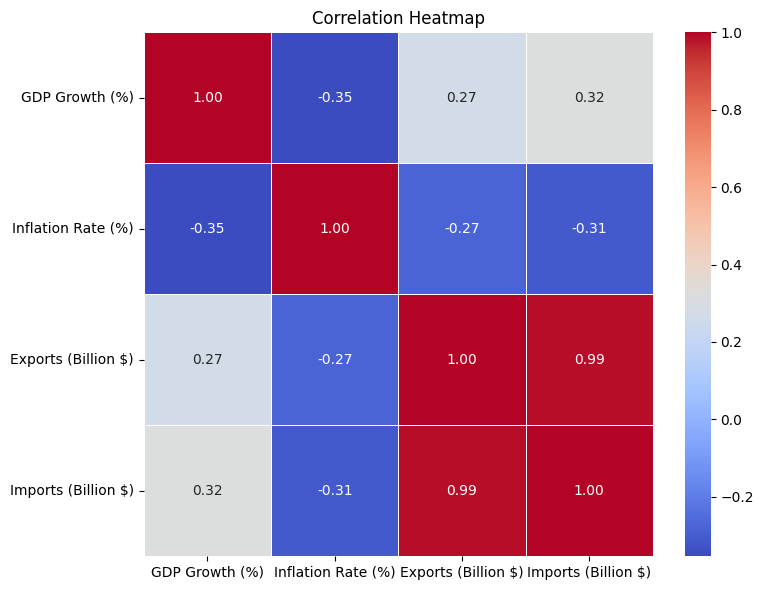

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the numerical columns from data_cleaned
data_cleaned_numeric = data_cleaned[['GDP Growth (%)', 'Inflation Rate (%)', 'Exports (Billion $)', 'Imports (Billion $)']]

# Pairplot to analyze relationships between variables
sns.pairplot(data_cleaned_numeric, diag_kind='hist', markers='+')
plt.suptitle("Pairwise Relationships Between Key Variables", y=1.02)
plt.tight_layout()
plt.show()

# Correlation matrix for key variables
correlation_matrix = data_cleaned_numeric.corr()

# Displaying the correlation matrix
print("Correlation Matrix of Key Variables:")
print(correlation_matrix)

# Heatmap for visualizing correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

    Year  Predicted GDP Growth (%)
59  2024                  0.027172
60  2025                  0.032395
61  2026                  0.034419
62  2027                  0.035204
63  2028                  0.035508


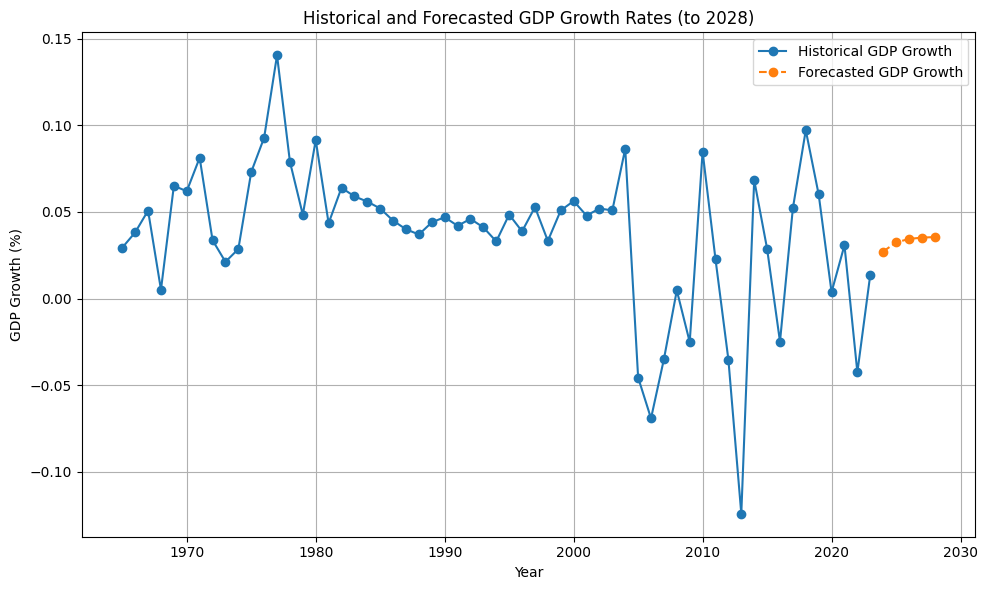

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Prepare the GDP growth series for time series analysis
gdp_growth_series = data_cleaned.set_index("Year")["GDP Growth (%)"].reset_index(drop=True)

# Fit the ARIMA model (p=1, d=1, q=1)
model = ARIMA(gdp_growth_series, order=(1, 1, 1))
fitted_model = model.fit()

# Forecast GDP Growth to 2028 (5 years beyond 2023)
forecast_years = 2028 - 2023
forecast = fitted_model.forecast(steps=forecast_years)

# Create a DataFrame for the forecasted results
forecast_years_index = list(range(2024, 2029))  # Years 2024 to 2028
forecast_df = pd.DataFrame({'Year': forecast_years_index, 'Predicted GDP Growth (%)': forecast})

# Display forecasted values
print(forecast_df)


plt.figure(figsize=(10, 6))
plt.plot(range(2023 - len(gdp_growth_series) + 1, 2023 + 1), gdp_growth_series, label="Historical GDP Growth", marker='o')
plt.plot(forecast_years_index, forecast, label="Forecasted GDP Growth", marker='o', linestyle='--')
plt.title("Historical and Forecasted GDP Growth Rates (to 2028)")
plt.xlabel("Year")
plt.ylabel("GDP Growth (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
